<a href="https://colab.research.google.com/github/ee17b031-iittp/DCGAN/blob/master/mnist_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def discrimnator(in_sh = (28, 28, 1)):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64, kernel_size= (3,3), padding='same', input_shape = in_sh))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Conv2D(64, kernel_size= (3,3), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5), metrics= ['accuracy'])
  return model

In [ ]:
def generator(latent_dim):
  model = tf.keras.models.Sequential()
  initial_nodes = 128*7*7
  model.add(tf.keras.layers.Dense(initial_nodes, input_shape = (latent_dim,)))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Reshape((7, 7, 128)))
  model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Conv2D(1, kernel_size=(7, 7), activation='tanh', padding='same'))
  return model

In [ ]:
def dcgan(disc, gen):
  disc.trainable = False
  model = tf.keras.models.Sequential()
  model.add(gen)
  model.add(disc)

  model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics = ['accuracy'])
  return model

In [ ]:
def preprocess(img, label):
  return tf.divide(tf.cast(img,tf.float32) - tf.constant(127.5), 127.5)

In [ ]:
batch_size = 64

In [ ]:
ds_train, ds_info = tfds.load(name='mnist',split=['train'],shuffle_files=True, as_supervised=True, with_info= True)
ds_train = ds_train[0].shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache('./traindata')
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [ ]:
def gen_latent_points(latent_dim, batch_size):
  return tf.random.normal([batch_size, latent_dim])

In [ ]:
def generate_fake_samples(gen, latent_dim, batch_size):
  return gen.predict(gen_latent_points(latent_dim, batch_size)), tf.zeros(shape=[batch_size, 1])

In [ ]:
def deprocess(img):
  img = arg = tf.convert_to_tensor(img, dtype=tf.float32)
  return tf.multiply(tf.cast(img,tf.float32),tf.constant(127.5)) + tf.constant(127.5)

In [ ]:
def show_plot(examples):
  n = 5
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray')
  plt.show()

In [ ]:
def train(latent_dim, disc, gen, gan, train_set, batch_size, num_epochs = 200):
  for i in range(num_epochs):
    dis_acc_real = 0
    dis_acc_fake = 0
    gan_acc_ = 0
    count = 0
    dis_loss_real = 0
    dis_loss_fake = 0
    gan_loss_ = 0
    for train_batch in train_set:
      count += 1
      sh = train_batch.get_shape().as_list()
      train_labels = tf.ones(shape=[sh[0], 1])
      fake_batch, fake_labels = generate_fake_samples(gen, latent_dim, sh[0])
      _, _ = disc.train_on_batch(tf.concat([train_batch, fake_batch], 0), tf.concat([train_labels, fake_labels], 0))
      latent_fake_points = gen_latent_points(latent_dim, 2*sh[0])
      latent_points_labels = tf.ones(shape=[2*sh[0], 1])
      _, _ = gan.train_on_batch(latent_fake_points, latent_points_labels)
      test_dis_samples_real = train_batch
      test_dis_samples_fake = fake_batch
      test_dis_labels_real = train_labels
      test_dis_labels_fake = fake_labels
      dis_loss1, dis_acc1 = disc.evaluate(test_dis_samples_real, test_dis_labels_real, verbose = 0)
      dis_loss2, dis_acc2 = disc.evaluate(test_dis_samples_fake, test_dis_labels_fake, verbose = 0)
      gan_loss, gan_acc = gan.evaluate(latent_fake_points, latent_points_labels, verbose = 0)
      dis_acc_real += dis_acc1
      dis_acc_fake += dis_acc2
      gan_acc_ += gan_acc
      dis_loss_real += dis_loss1
      dis_loss_fake += dis_loss2
      gan_loss_ += gan_loss
    gen.save('/content/drive/My Drive/MNIST_dcgan/generator.h5')
    print("epoch: ", i,"real samples discriminator accuracy: ", (dis_acc_real/count)*100,"%", "real samples discriminator loss: ", (dis_loss_real/count), "fake samples discriminator accuracy: ", (dis_acc_fake/count)*100, "%", "fake samples discriminator loss: ", (dis_loss_fake/count))
    print('DCGAN accuracy:', (gan_acc_/count)*100, "%", 'DCGAN loss:', (gan_loss_/count))
    im = tf.identity(fake_batch).numpy()
    show_plot(im)

In [ ]:
latent_dim = 100
gen = generator(latent_dim)
dis = discrimnator()
gan = dcgan(dis, gen)

epoch:  0 real samples discriminator accuracy:  53.82296108742004 % real samples discriminator loss:  0.6808686330199623 fake samples discriminator accuracy:  87.73154317697228 % fake samples discriminator loss:  0.4679406810460537
DCGAN accuracy: 20.527385394456292 % DCGAN loss: 1.0103972179096328


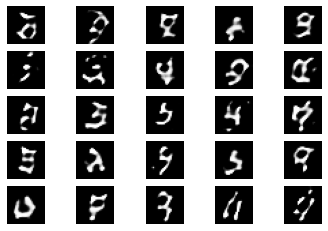

epoch:  1 real samples discriminator accuracy:  55.60034648187633 % real samples discriminator loss:  0.7001256450597666 fake samples discriminator accuracy:  91.15804904051173 % fake samples discriminator loss:  0.5074097081097458
DCGAN accuracy: 15.689132462686567 % DCGAN loss: 0.8871083823856769


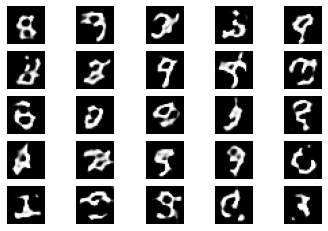

epoch:  2 real samples discriminator accuracy:  65.51339285714286 % real samples discriminator loss:  0.6384108619712817 fake samples discriminator accuracy:  84.23174307036247 % fake samples discriminator loss:  0.5507550409226529
DCGAN accuracy: 26.43007062899787 % DCGAN loss: 0.8197886108208313


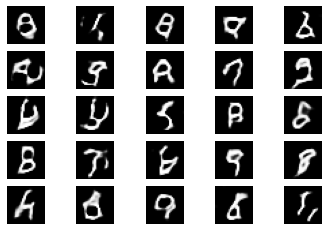

epoch:  3 real samples discriminator accuracy:  64.20908848614071 % real samples discriminator loss:  0.6486556746367452 fake samples discriminator accuracy:  83.9785447761194 % fake samples discriminator loss:  0.5649177466056494
DCGAN accuracy: 26.80487073560768 % DCGAN loss: 0.8008305950840907


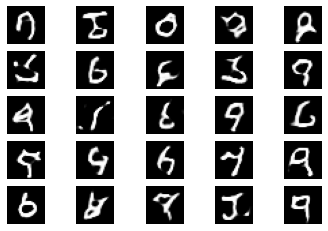

epoch:  4 real samples discriminator accuracy:  63.667710554371006 % real samples discriminator loss:  0.6511034918492282 fake samples discriminator accuracy:  84.9746801705757 % fake samples discriminator loss:  0.5659275151201403
DCGAN accuracy: 24.343683368869936 % DCGAN loss: 0.8056061093105691


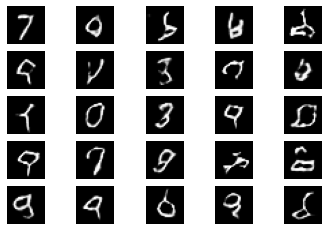

epoch:  5 real samples discriminator accuracy:  60.269522921108745 % real samples discriminator loss:  0.6643919924746698 fake samples discriminator accuracy:  87.3167643923241 % fake samples discriminator loss:  0.5546250693452384
DCGAN accuracy: 21.41108075692964 % DCGAN loss: 0.8185086247127956


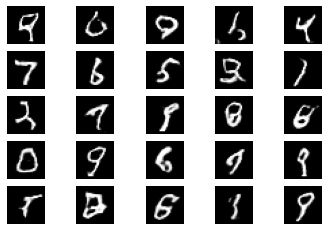

epoch:  6 real samples discriminator accuracy:  59.886393923240945 % real samples discriminator loss:  0.6652438706998378 fake samples discriminator accuracy:  86.81536513859275 % fake samples discriminator loss:  0.5605183065827213
DCGAN accuracy: 22.058235607675904 % DCGAN loss: 0.8124563912592971


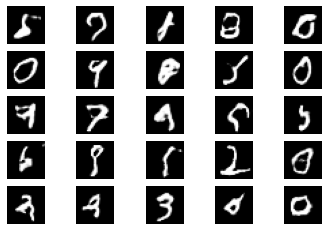

epoch:  7 real samples discriminator accuracy:  54.54091151385928 % real samples discriminator loss:  0.6848636694045972 fake samples discriminator accuracy:  88.04137793176973 % fake samples discriminator loss:  0.5606751069267676
DCGAN accuracy: 19.194762793176974 % DCGAN loss: 0.8192789883120482


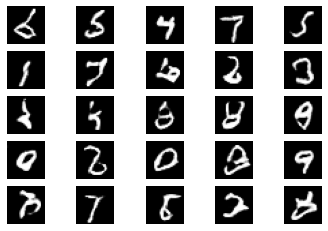

epoch:  8 real samples discriminator accuracy:  52.81683102345416 % real samples discriminator loss:  0.6897011085359781 fake samples discriminator accuracy:  87.34341684434968 % fake samples discriminator loss:  0.5709099508107089
DCGAN accuracy: 19.475446428571427 % DCGAN loss: 0.8095270085817715


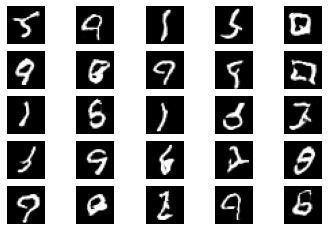

epoch:  9 real samples discriminator accuracy:  51.1743736673774 % real samples discriminator loss:  0.6949432730547654 fake samples discriminator accuracy:  86.55883528784648 % fake samples discriminator loss:  0.5804870477808055
DCGAN accuracy: 19.62703224946695 % DCGAN loss: 0.8021925915914304


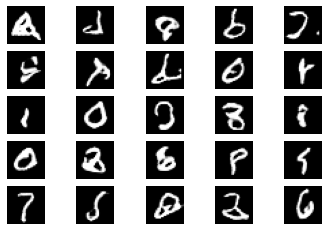

epoch:  10 real samples discriminator accuracy:  50.72294776119403 % real samples discriminator loss:  0.6964529914769537 fake samples discriminator accuracy:  85.39778784648188 % fake samples discriminator loss:  0.5844235163189964
DCGAN accuracy: 21.433568763326228 % DCGAN loss: 0.7940077000081158


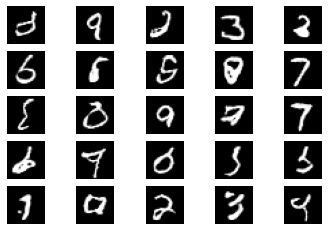

epoch:  11 real samples discriminator accuracy:  49.713486140724946 % real samples discriminator loss:  0.6976397324091336 fake samples discriminator accuracy:  85.11627132196162 % fake samples discriminator loss:  0.5935502503472351
DCGAN accuracy: 21.33029051172708 % DCGAN loss: 0.7862568519898315


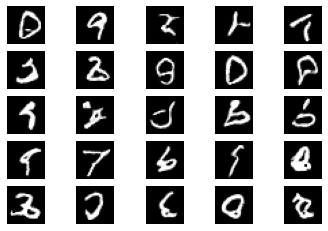

epoch:  12 real samples discriminator accuracy:  51.001132729211086 % real samples discriminator loss:  0.695013011505863 fake samples discriminator accuracy:  84.48327558635394 % fake samples discriminator loss:  0.6000664565863132
DCGAN accuracy: 22.523820628997868 % DCGAN loss: 0.7786016787038937


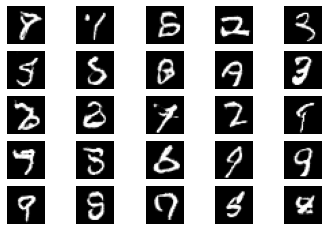

epoch:  13 real samples discriminator accuracy:  48.94556236673774 % real samples discriminator loss:  0.6998735710756102 fake samples discriminator accuracy:  84.98967217484008 % fake samples discriminator loss:  0.5990743590062106
DCGAN accuracy: 21.648454157782517 % DCGAN loss: 0.7806157896132357


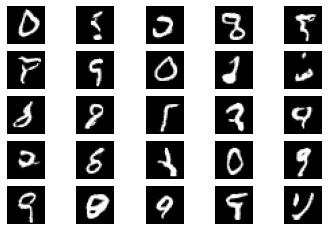

epoch:  14 real samples discriminator accuracy:  49.69849413646055 % real samples discriminator loss:  0.6967461546346831 fake samples discriminator accuracy:  84.07182835820896 % fake samples discriminator loss:  0.6054274530680195
DCGAN accuracy: 22.59461620469083 % DCGAN loss: 0.7730834008788249


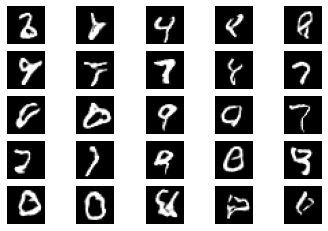

epoch:  15 real samples discriminator accuracy:  47.982742537313435 % real samples discriminator loss:  0.7020432271047442 fake samples discriminator accuracy:  84.5632329424307 % fake samples discriminator loss:  0.6025702727120569
DCGAN accuracy: 21.687599946695098 % DCGAN loss: 0.776423733308117


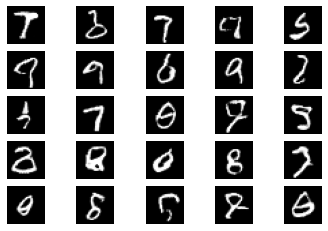

epoch:  16 real samples discriminator accuracy:  48.0360474413646 % real samples discriminator loss:  0.7012522724518644 fake samples discriminator accuracy:  84.69816098081023 % fake samples discriminator loss:  0.6048863564472972
DCGAN accuracy: 22.12903118336887 % DCGAN loss: 0.772879146055372


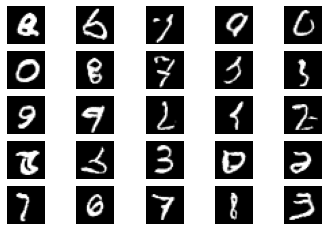

epoch:  17 real samples discriminator accuracy:  47.4613539445629 % real samples discriminator loss:  0.702632390105648 fake samples discriminator accuracy:  84.769789445629 % fake samples discriminator loss:  0.6063012534748516
DCGAN accuracy: 21.807535980810236 % DCGAN loss: 0.7720520020420871


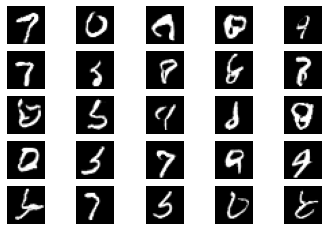

epoch:  18 real samples discriminator accuracy:  45.60567697228145 % real samples discriminator loss:  0.7071101863119902 fake samples discriminator accuracy:  85.60267857142857 % fake samples discriminator loss:  0.6056642229877301
DCGAN accuracy: 20.43077025586354 % DCGAN loss: 0.7741140530053486


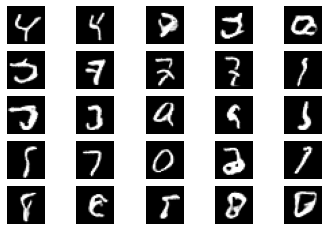

epoch:  19 real samples discriminator accuracy:  43.47681236673774 % real samples discriminator loss:  0.7117846662810108 fake samples discriminator accuracy:  86.71042110874201 % fake samples discriminator loss:  0.6028466645969766
DCGAN accuracy: 18.759161780383796 % DCGAN loss: 0.7778167972432525


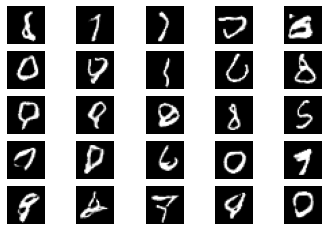

epoch:  20 real samples discriminator accuracy:  43.588419509594885 % real samples discriminator loss:  0.7111701598045415 fake samples discriminator accuracy:  86.5338486140725 % fake samples discriminator loss:  0.6045991097177777
DCGAN accuracy: 19.60287846481876 % DCGAN loss: 0.7747682829274297


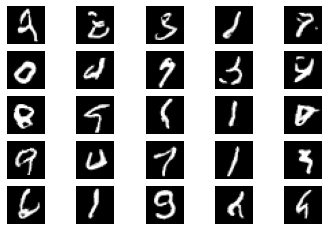

epoch:  21 real samples discriminator accuracy:  40.343483475479744 % real samples discriminator loss:  0.7180673705616485 fake samples discriminator accuracy:  88.4828091684435 % fake samples discriminator loss:  0.5992857204444373
DCGAN accuracy: 17.046741737739872 % DCGAN loss: 0.78148783663951


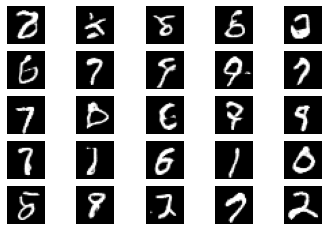

epoch:  22 real samples discriminator accuracy:  36.84368336886993 % real samples discriminator loss:  0.7260607236356877 fake samples discriminator accuracy:  89.93203624733475 % fake samples discriminator loss:  0.5954575078573816
DCGAN accuracy: 14.971182036247335 % DCGAN loss: 0.7864004126362709


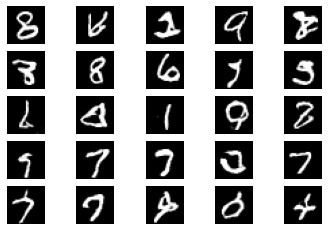

epoch:  23 real samples discriminator accuracy:  37.131863006396586 % real samples discriminator loss:  0.7259475312380395 fake samples discriminator accuracy:  89.88206289978679 % fake samples discriminator loss:  0.5977755748132653
DCGAN accuracy: 15.282682569296375 % DCGAN loss: 0.7838980725197904


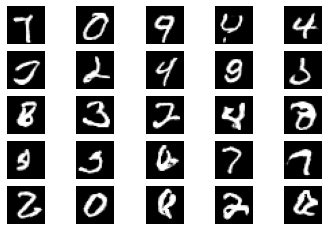

epoch:  24 real samples discriminator accuracy:  36.3389525586354 % real samples discriminator loss:  0.7265889705625425 fake samples discriminator accuracy:  90.10027985074626 % fake samples discriminator loss:  0.5971231867255432
DCGAN accuracy: 14.663013059701493 % DCGAN loss: 0.7849454631302148


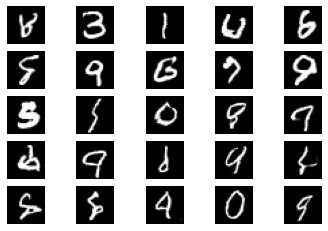

epoch:  25 real samples discriminator accuracy:  35.24453624733476 % real samples discriminator loss:  0.7293290054238936 fake samples discriminator accuracy:  90.46508528784648 % fake samples discriminator loss:  0.5965987008009384
DCGAN accuracy: 14.066664445628998 % DCGAN loss: 0.7859671726536903


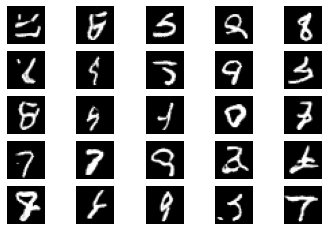

epoch:  26 real samples discriminator accuracy:  33.27725213219616 % real samples discriminator loss:  0.734215715419509 fake samples discriminator accuracy:  91.5911513859275 % fake samples discriminator loss:  0.5901351425248677
DCGAN accuracy: 12.923940565031982 % DCGAN loss: 0.7925580757131963


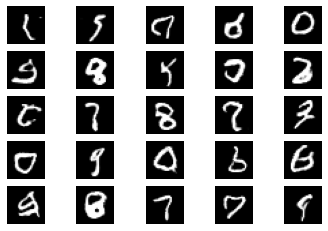

epoch:  27 real samples discriminator accuracy:  33.53045042643924 % real samples discriminator loss:  0.733929223279709 fake samples discriminator accuracy:  91.63113006396588 % fake samples discriminator loss:  0.5901137263790123
DCGAN accuracy: 13.068863272921108 % DCGAN loss: 0.7925479685319766


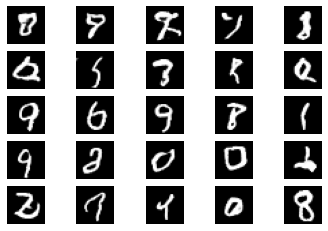

epoch:  28 real samples discriminator accuracy:  28.393190298507463 % real samples discriminator loss:  0.746197927353987 fake samples discriminator accuracy:  93.90491737739872 % fake samples discriminator loss:  0.5818254651545461
DCGAN accuracy: 9.652352078891258 % DCGAN loss: 0.8037021638615045


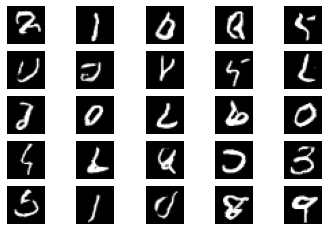

epoch:  29 real samples discriminator accuracy:  28.396521855010658 % real samples discriminator loss:  0.7464585201953774 fake samples discriminator accuracy:  93.86660447761194 % fake samples discriminator loss:  0.5807755176446585
DCGAN accuracy: 10.032982409381663 % DCGAN loss: 0.8043891174961001


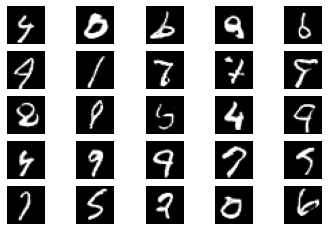

epoch:  30 real samples discriminator accuracy:  28.06336620469083 % real samples discriminator loss:  0.7485046561465842 fake samples discriminator accuracy:  93.70002665245202 % fake samples discriminator loss:  0.57916873502833
DCGAN accuracy: 9.849746801705757 % DCGAN loss: 0.8065299226531087


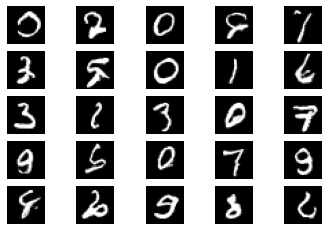

epoch:  31 real samples discriminator accuracy:  25.45309168443497 % real samples discriminator loss:  0.7523668857017306 fake samples discriminator accuracy:  95.10261194029852 % fake samples discriminator loss:  0.5770613695703336
DCGAN accuracy: 7.964085820895522 % DCGAN loss: 0.8098319131555334


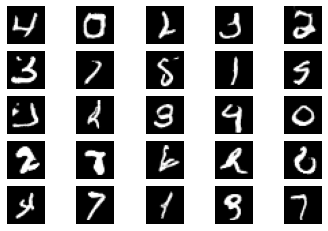

epoch:  32 real samples discriminator accuracy:  25.681303304904052 % real samples discriminator loss:  0.7522875676150007 fake samples discriminator accuracy:  94.80443763326227 % fake samples discriminator loss:  0.5766676572530762
DCGAN accuracy: 8.070695628997868 % DCGAN loss: 0.810633667369387


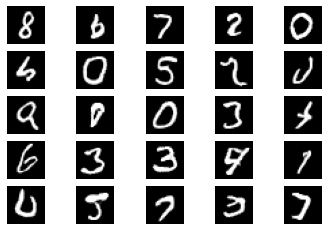

epoch:  33 real samples discriminator accuracy:  25.76292643923241 % real samples discriminator loss:  0.7527322664952227 fake samples discriminator accuracy:  94.69949360341151 % fake samples discriminator loss:  0.5762403086304411
DCGAN accuracy: 8.407182835820896 % DCGAN loss: 0.8106724601437543


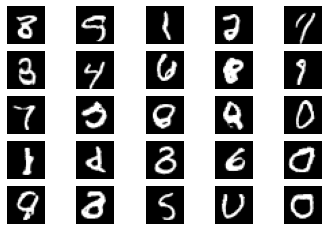

epoch:  34 real samples discriminator accuracy:  21.395255863539443 % real samples discriminator loss:  0.7645922370556829 fake samples discriminator accuracy:  96.0970815565032 % fake samples discriminator loss:  0.5675413888146374
DCGAN accuracy: 6.195029317697228 % DCGAN loss: 0.822882619366717


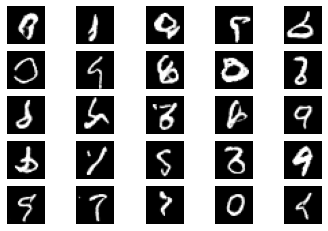

epoch:  35 real samples discriminator accuracy:  19.544576226012794 % real samples discriminator loss:  0.7693925769344322 fake samples discriminator accuracy:  96.66677771855011 % fake samples discriminator loss:  0.564083914766942
DCGAN accuracy: 5.183901918976546 % DCGAN loss: 0.8271791531460118


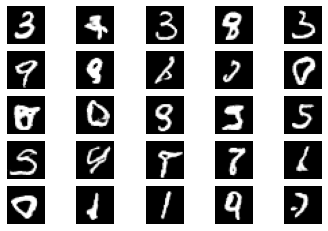

epoch:  36 real samples discriminator accuracy:  17.425706289978677 % real samples discriminator loss:  0.7764130420903407 fake samples discriminator accuracy:  97.26312633262259 % fake samples discriminator loss:  0.5578518644261208
DCGAN accuracy: 4.469283049040511 % DCGAN loss: 0.8351287355682234


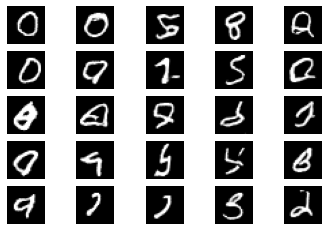

epoch:  37 real samples discriminator accuracy:  18.638392857142858 % real samples discriminator loss:  0.7723399510642867 fake samples discriminator accuracy:  97.0599013859275 % fake samples discriminator loss:  0.5606085205637316
DCGAN accuracy: 4.847414712153518 % DCGAN loss: 0.8309099522353743


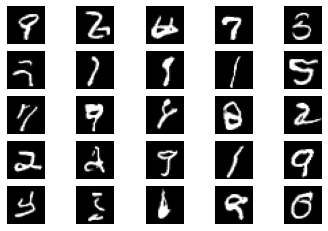

epoch:  38 real samples discriminator accuracy:  20.444096481876333 % real samples discriminator loss:  0.7704160956304464 fake samples discriminator accuracy:  96.84335021321961 % fake samples discriminator loss:  0.5603371607596432
DCGAN accuracy: 5.425439765458422 % DCGAN loss: 0.8309627203926094


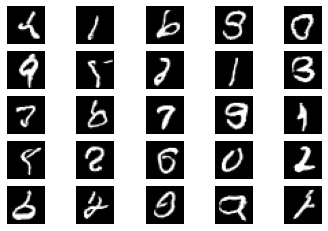

epoch:  39 real samples discriminator accuracy:  20.482409381663114 % real samples discriminator loss:  0.7680268940259652 fake samples discriminator accuracy:  96.6900986140725 % fake samples discriminator loss:  0.5626517312486035
DCGAN accuracy: 5.673640724946695 % DCGAN loss: 0.8282600483025061


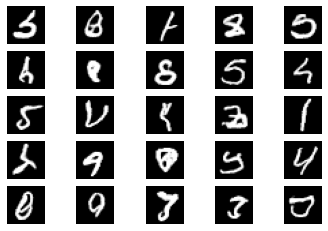

epoch:  40 real samples discriminator accuracy:  18.276918976545844 % real samples discriminator loss:  0.7774427742210787 fake samples discriminator accuracy:  97.16817697228144 % fake samples discriminator loss:  0.5552124258424682
DCGAN accuracy: 4.571728411513859 % DCGAN loss: 0.8381062459462741


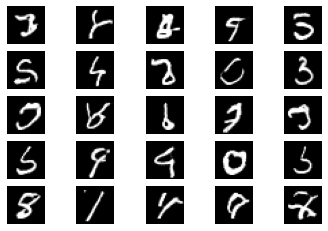

epoch:  41 real samples discriminator accuracy:  18.490138592750533 % real samples discriminator loss:  0.7745584429962549 fake samples discriminator accuracy:  97.35974147121536 % fake samples discriminator loss:  0.5562551555666588
DCGAN accuracy: 4.644189765458422 % DCGAN loss: 0.8364206412072375


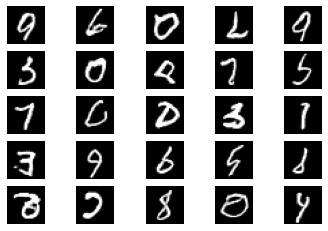

epoch:  42 real samples discriminator accuracy:  16.209688166311302 % real samples discriminator loss:  0.7838452757040321 fake samples discriminator accuracy:  97.93110341151386 % fake samples discriminator loss:  0.5491330071425895
DCGAN accuracy: 3.6438899253731347 % DCGAN loss: 0.8465511380736508


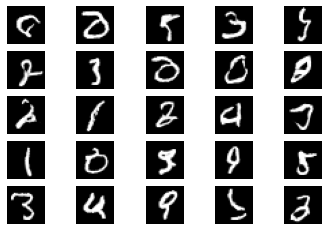

epoch:  43 real samples discriminator accuracy:  14.940365138592751 % real samples discriminator loss:  0.7884156684250211 fake samples discriminator accuracy:  98.08102345415777 % fake samples discriminator loss:  0.5455380960314005
DCGAN accuracy: 3.1708089019189765 % DCGAN loss: 0.8518467136918862


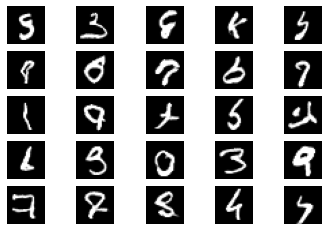

epoch:  44 real samples discriminator accuracy:  13.627731876332621 % real samples discriminator loss:  0.7928269559513531 fake samples discriminator accuracy:  98.53744669509595 % fake samples discriminator loss:  0.540764285144267
DCGAN accuracy: 2.5769589552238807 % DCGAN loss: 0.8580472108397657


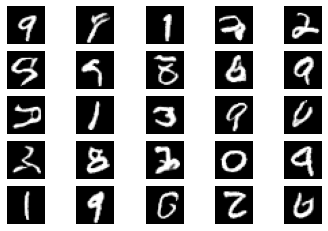

epoch:  45 real samples discriminator accuracy:  14.652185501066098 % real samples discriminator loss:  0.7928101693007992 fake samples discriminator accuracy:  98.35754264392324 % fake samples discriminator loss:  0.5396510736901623
DCGAN accuracy: 2.9326026119402986 % DCGAN loss: 0.858611619548757


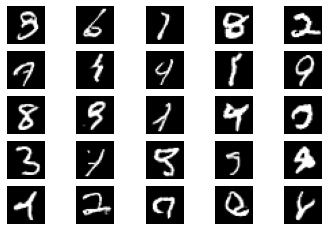

epoch:  46 real samples discriminator accuracy:  11.31230010660981 % real samples discriminator loss:  0.810385564242853 fake samples discriminator accuracy:  98.96721748400853 % fake samples discriminator loss:  0.5262350646226899
DCGAN accuracy: 1.8248600746268657 % DCGAN loss: 0.8780275021534739


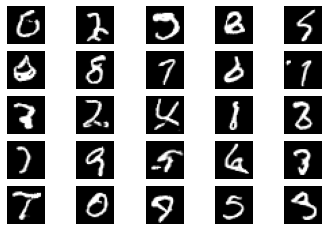

epoch:  47 real samples discriminator accuracy:  11.3272921108742 % real samples discriminator loss:  0.8093962294460614 fake samples discriminator accuracy:  98.93556769722814 % fake samples discriminator loss:  0.5264284245685728
DCGAN accuracy: 1.887326759061834 % DCGAN loss: 0.8776286489673769


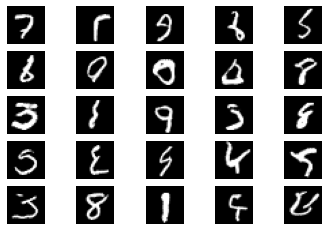

epoch:  48 real samples discriminator accuracy:  10.849213752665245 % real samples discriminator loss:  0.8121470968479286 fake samples discriminator accuracy:  99.08881929637526 % fake samples discriminator loss:  0.524675412059847
DCGAN accuracy: 1.6466218017057568 % DCGAN loss: 0.8810032881272118


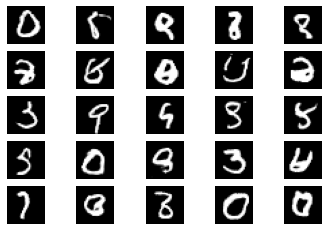

epoch:  49 real samples discriminator accuracy:  9.26006130063966 % real samples discriminator loss:  0.8221586323114854 fake samples discriminator accuracy:  99.37033582089553 % fake samples discriminator loss:  0.5163873862991455
DCGAN accuracy: 1.185201226012793 % DCGAN loss: 0.8938591402095518


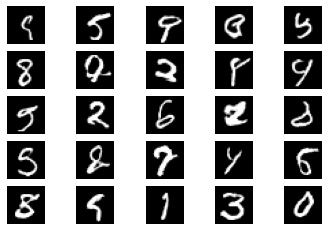

epoch:  50 real samples discriminator accuracy:  10.167910447761194 % real samples discriminator loss:  0.8205753587075134 fake samples discriminator accuracy:  99.24207089552239 % fake samples discriminator loss:  0.5155475727721318
DCGAN accuracy: 1.3892590618336886 % DCGAN loss: 0.8937944563340022


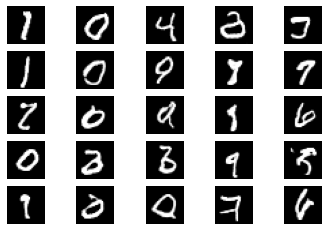

epoch:  51 real samples discriminator accuracy:  8.978544776119403 % real samples discriminator loss:  0.8250234064771168 fake samples discriminator accuracy:  99.42863805970148 % fake samples discriminator loss:  0.5120858850954438
DCGAN accuracy: 1.0219549573560769 % DCGAN loss: 0.8986559497522139


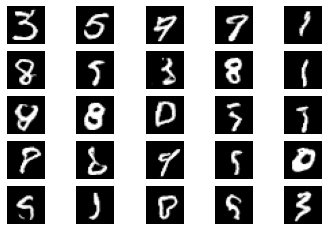

epoch:  52 real samples discriminator accuracy:  9.346681769722814 % real samples discriminator loss:  0.8295018426390853 fake samples discriminator accuracy:  99.45862206823027 % fake samples discriminator loss:  0.5056247690847433
DCGAN accuracy: 1.0777585287846483 % DCGAN loss: 0.9082261664526803


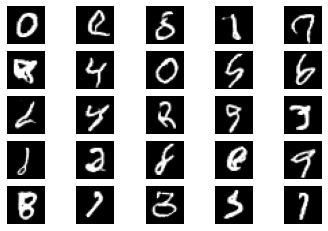

epoch:  53 real samples discriminator accuracy:  7.804171108742004 % real samples discriminator loss:  0.8410159619505218 fake samples discriminator accuracy:  99.66851012793177 % fake samples discriminator loss:  0.4981082099269448
DCGAN accuracy: 0.685467750533049 % DCGAN loss: 0.9206025693843614


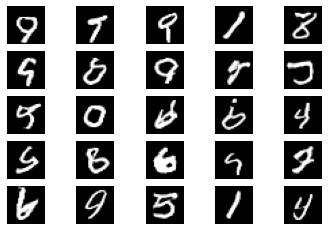

epoch:  54 real samples discriminator accuracy:  8.26226012793177 % real samples discriminator loss:  0.8426691968557931 fake samples discriminator accuracy:  99.65684968017058 % fake samples discriminator loss:  0.4949964417069197
DCGAN accuracy: 0.64465618336887 % DCGAN loss: 0.9259308137492076


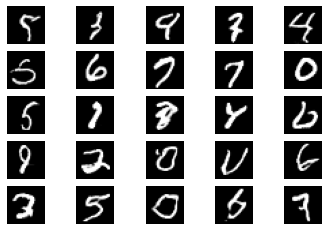

epoch:  55 real samples discriminator accuracy:  7.535980810234541 % real samples discriminator loss:  0.8521099049907758 fake samples discriminator accuracy:  99.71015458422174 % fake samples discriminator loss:  0.4861962084195761
DCGAN accuracy: 0.6063432835820896 % DCGAN loss: 0.9376507271835799


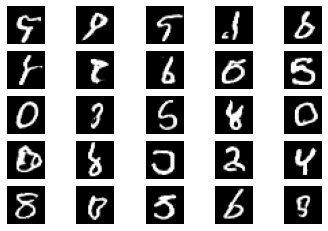

epoch:  56 real samples discriminator accuracy:  8.352212153518124 % real samples discriminator loss:  0.84937363106813 fake samples discriminator accuracy:  99.64852078891258 % fake samples discriminator loss:  0.4863576244380174
DCGAN accuracy: 0.8029051172707888 % DCGAN loss: 0.9371738245746474


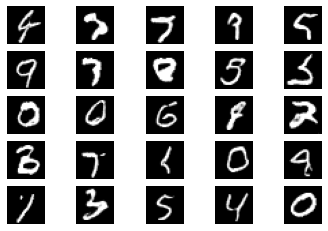

epoch:  57 real samples discriminator accuracy:  7.939099147121535 % real samples discriminator loss:  0.8520178211523272 fake samples discriminator accuracy:  99.67350746268657 % fake samples discriminator loss:  0.48380567670376823
DCGAN accuracy: 0.6463219616204691 % DCGAN loss: 0.941521166484239


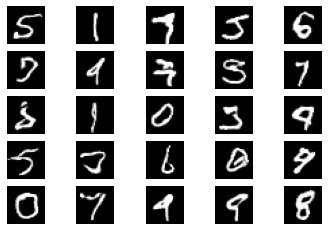

epoch:  58 real samples discriminator accuracy:  7.416044776119403 % real samples discriminator loss:  0.8576451245147282 fake samples discriminator accuracy:  99.7867803837953 % fake samples discriminator loss:  0.47765610873826275
DCGAN accuracy: 0.49057169509594883 % DCGAN loss: 0.9505211388124332


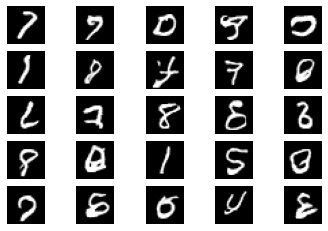

epoch:  59 real samples discriminator accuracy:  8.717017590618337 % real samples discriminator loss:  0.8526643763727216 fake samples discriminator accuracy:  99.69682835820896 % fake samples discriminator loss:  0.4783929620724497
DCGAN accuracy: 0.5888526119402985 % DCGAN loss: 0.9497829769720146


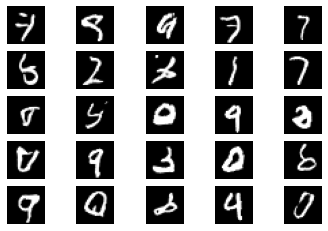

epoch:  60 real samples discriminator accuracy:  8.173973880597014 % real samples discriminator loss:  0.8593044511036578 fake samples discriminator accuracy:  99.75846215351812 % fake samples discriminator loss:  0.47284590813523925
DCGAN accuracy: 0.5113939232409381 % DCGAN loss: 0.9590041877618477


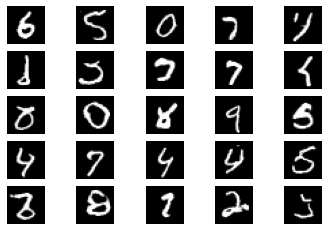

epoch:  61 real samples discriminator accuracy:  7.462686567164178 % real samples discriminator loss:  0.878099317870923 fake samples discriminator accuracy:  99.75679637526652 % fake samples discriminator loss:  0.46043925428949695
DCGAN accuracy: 0.4655850213219616 % DCGAN loss: 0.9810166839343398


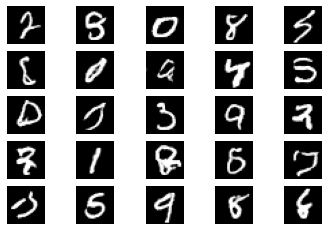

epoch:  62 real samples discriminator accuracy:  7.409381663113006 % real samples discriminator loss:  0.8783060502904311 fake samples discriminator accuracy:  99.85341151385929 % fake samples discriminator loss:  0.4586456969920506
DCGAN accuracy: 0.3723014392324094 % DCGAN loss: 0.9830986007190208


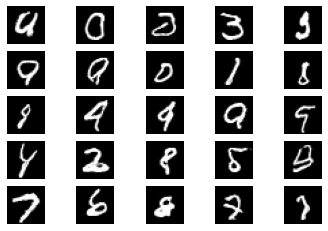

epoch:  63 real samples discriminator accuracy:  7.727545309168443 % real samples discriminator loss:  0.87451234777599 fake samples discriminator accuracy:  99.8034381663113 % fake samples discriminator loss:  0.4595826223079584
DCGAN accuracy: 0.40561700426439234 % DCGAN loss: 0.9806294952120099


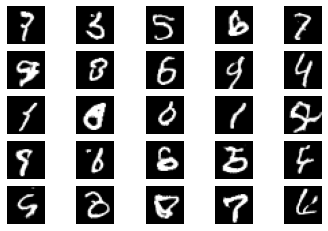

epoch:  64 real samples discriminator accuracy:  7.645922174840085 % real samples discriminator loss:  0.8845991278126804 fake samples discriminator accuracy:  99.77345415778251 % fake samples discriminator loss:  0.45083042537606854
DCGAN accuracy: 0.43310234541577824 % DCGAN loss: 0.9966201834968412


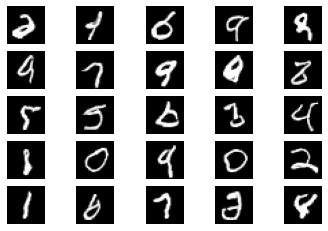

epoch:  65 real samples discriminator accuracy:  8.432169509594882 % real samples discriminator loss:  0.8793988594495411 fake samples discriminator accuracy:  99.8017723880597 % fake samples discriminator loss:  0.45096490460672356
DCGAN accuracy: 0.4072827825159915 % DCGAN loss: 0.9952165179415298


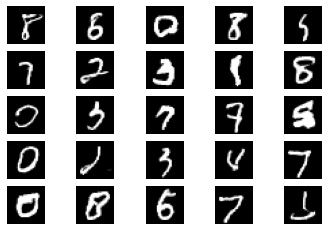

epoch:  66 real samples discriminator accuracy:  7.83248933901919 % real samples discriminator loss:  0.8909855505296671 fake samples discriminator accuracy:  99.7867803837953 % fake samples discriminator loss:  0.44306293504832905
DCGAN accuracy: 0.4480943496801706 % DCGAN loss: 1.0087164876811794


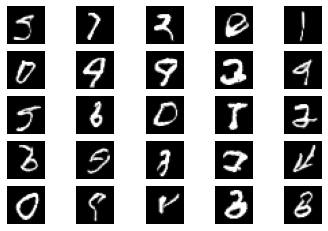

epoch:  67 real samples discriminator accuracy:  7.610940831556504 % real samples discriminator loss:  0.8967676885854969 fake samples discriminator accuracy:  99.87839818763327 % fake samples discriminator loss:  0.4373105837147373
DCGAN accuracy: 0.2765191897654584 % DCGAN loss: 1.0189850506370763


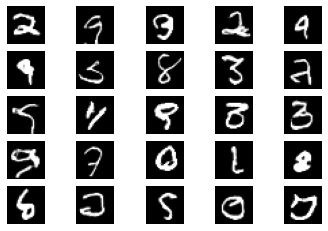

epoch:  68 real samples discriminator accuracy:  7.261127398720682 % real samples discriminator loss:  0.9037595039237537 fake samples discriminator accuracy:  99.83508795309169 % fake samples discriminator loss:  0.4329481980503241
DCGAN accuracy: 0.31316631130063965 % DCGAN loss: 1.0275120376142612


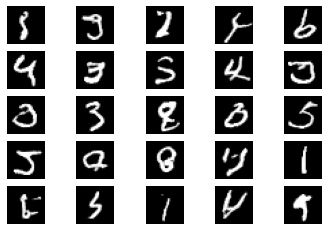

epoch:  69 real samples discriminator accuracy:  7.544309701492537 % real samples discriminator loss:  0.9054048210064739 fake samples discriminator accuracy:  99.86340618336888 % fake samples discriminator loss:  0.4304066545673525
DCGAN accuracy: 0.27318763326226014 % DCGAN loss: 1.0320095709010737


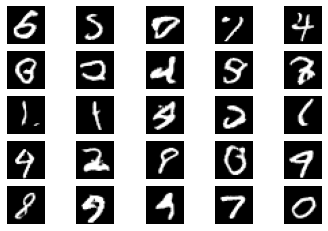

epoch:  70 real samples discriminator accuracy:  7.274453624733475 % real samples discriminator loss:  0.914575942543778 fake samples discriminator accuracy:  99.89838752665246 % fake samples discriminator loss:  0.4233941822799284
DCGAN accuracy: 0.22238139658848616 % DCGAN loss: 1.0449956009891241


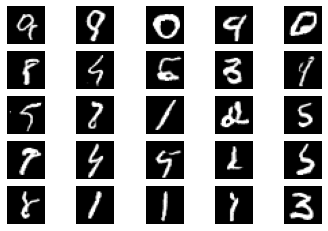

epoch:  71 real samples discriminator accuracy:  7.997401385927505 % real samples discriminator loss:  0.9067909827491621 fake samples discriminator accuracy:  99.88339552238806 % fake samples discriminator loss:  0.4266892230904687
DCGAN accuracy: 0.2931769722814499 % DCGAN loss: 1.038497426489523


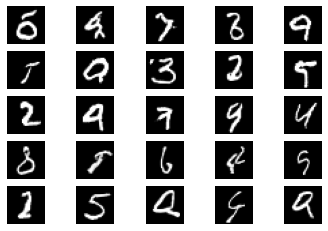

epoch:  72 real samples discriminator accuracy:  7.432702558635394 % real samples discriminator loss:  0.9224280373755295 fake samples discriminator accuracy:  99.87506663113007 % fake samples discriminator loss:  0.4155677017499643
DCGAN accuracy: 0.24320362473347548 % DCGAN loss: 1.0596149976192506


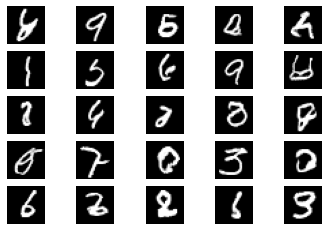

epoch:  73 real samples discriminator accuracy:  7.809168443496802 % real samples discriminator loss:  0.9201205163749296 fake samples discriminator accuracy:  99.88339552238806 % fake samples discriminator loss:  0.41566758483711846
DCGAN accuracy: 0.29067830490405117 % DCGAN loss: 1.0607704342936657


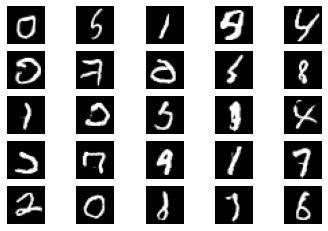

epoch:  74 real samples discriminator accuracy:  7.924107142857142 % real samples discriminator loss:  0.9271900155651036 fake samples discriminator accuracy:  99.88006396588486 % fake samples discriminator loss:  0.40961547065645393
DCGAN accuracy: 0.2548640724946695 % DCGAN loss: 1.071964080908151


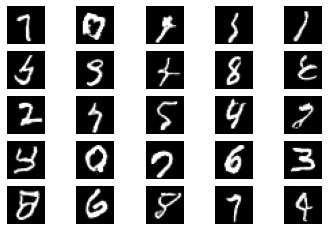

epoch:  75 real samples discriminator accuracy:  8.791977611940299 % real samples discriminator loss:  0.9193297650641216 fake samples discriminator accuracy:  99.79011194029852 % fake samples discriminator loss:  0.41339591784136637
DCGAN accuracy: 0.36397254797441364 % DCGAN loss: 1.0649452922440796


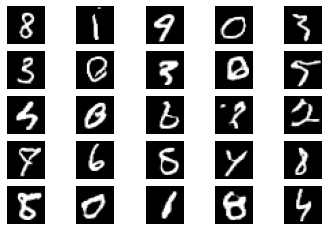

epoch:  76 real samples discriminator accuracy:  8.10567697228145 % real samples discriminator loss:  0.9333111080152394 fake samples discriminator accuracy:  99.89838752665246 % fake samples discriminator loss:  0.40356518935038843
DCGAN accuracy: 0.22904450959488273 % DCGAN loss: 1.0830119276351766


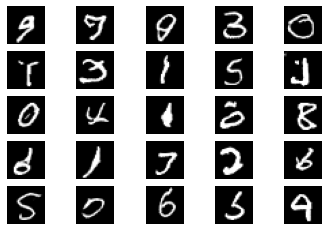

epoch:  77 real samples discriminator accuracy:  7.8924573560767595 % real samples discriminator loss:  0.9405118256235427 fake samples discriminator accuracy:  99.84841417910447 % fake samples discriminator loss:  0.3983251665955159
DCGAN accuracy: 0.28151652452025583 % DCGAN loss: 1.0928591137120465


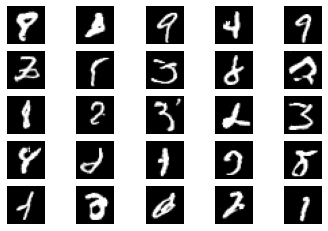

epoch:  78 real samples discriminator accuracy:  8.10401119402985 % real samples discriminator loss:  0.939186465829166 fake samples discriminator accuracy:  99.92337420042644 % fake samples discriminator loss:  0.39680980295260576
DCGAN accuracy: 0.20239205756929635 % DCGAN loss: 1.0959861236594632


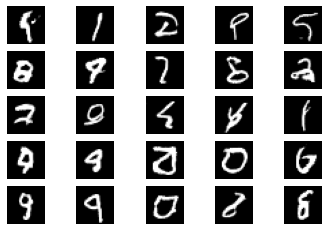

epoch:  79 real samples discriminator accuracy:  7.864139125799574 % real samples discriminator loss:  0.941912983208577 fake samples discriminator accuracy:  99.91337953091684 % fake samples discriminator loss:  0.39465391537400957
DCGAN accuracy: 0.1923973880597015 % DCGAN loss: 1.1003460151427336


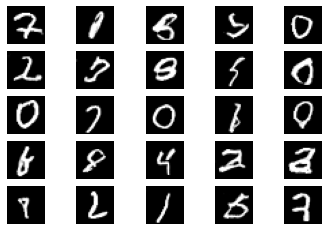

epoch:  80 real samples discriminator accuracy:  7.515991471215353 % real samples discriminator loss:  0.9534924078597697 fake samples discriminator accuracy:  99.89838752665246 % fake samples discriminator loss:  0.38834682345263233
DCGAN accuracy: 0.22488006396588484 % DCGAN loss: 1.114276557080527


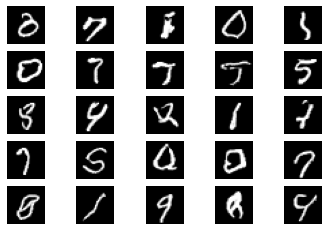

epoch:  81 real samples discriminator accuracy:  8.510461087420044 % real samples discriminator loss:  0.9507129529773045 fake samples discriminator accuracy:  99.87839818763327 % fake samples discriminator loss:  0.38806078160431845
DCGAN accuracy: 0.2965085287846482 % DCGAN loss: 1.1140530405522409


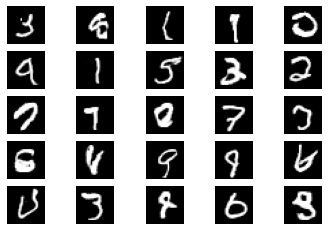

epoch:  82 real samples discriminator accuracy:  8.185634328358208 % real samples discriminator loss:  0.9498945532450035 fake samples discriminator accuracy:  99.91504530916845 % fake samples discriminator loss:  0.3864576673266222
DCGAN accuracy: 0.19073160980810233 % DCGAN loss: 1.1172272752342955


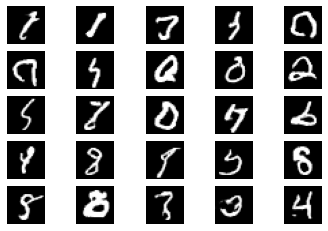

epoch:  83 real samples discriminator accuracy:  8.467150852878465 % real samples discriminator loss:  0.9534928705900717 fake samples discriminator accuracy:  99.88839285714286 % fake samples discriminator loss:  0.3833909428386546
DCGAN accuracy: 0.22154850746268656 % DCGAN loss: 1.1234296548849485


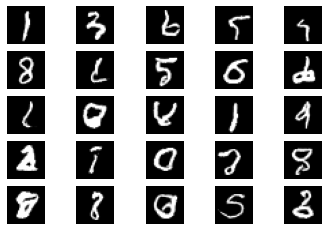

epoch:  84 real samples discriminator accuracy:  8.743670042643924 % real samples discriminator loss:  0.953761871626128 fake samples discriminator accuracy:  99.8217617270789 % fake samples discriminator loss:  0.38339672493400856
DCGAN accuracy: 0.3040045309168443 % DCGAN loss: 1.1253073524945834


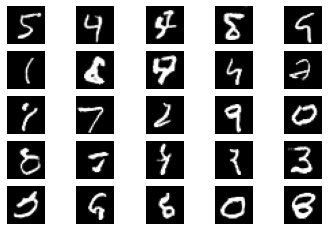

epoch:  85 real samples discriminator accuracy:  9.111807036247335 % real samples discriminator loss:  0.9512120867207614 fake samples discriminator accuracy:  99.88006396588486 % fake samples discriminator loss:  0.381673009887433
DCGAN accuracy: 0.21571828358208955 % DCGAN loss: 1.1285282417273979


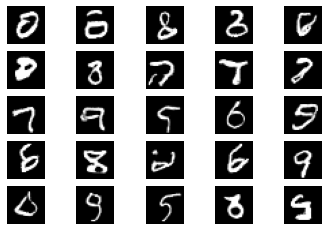

epoch:  86 real samples discriminator accuracy:  8.935234541577824 % real samples discriminator loss:  0.9557233084239432 fake samples discriminator accuracy:  99.92337420042644 % fake samples discriminator loss:  0.37789914345563347
DCGAN accuracy: 0.24320362473347548 % DCGAN loss: 1.135966657766147


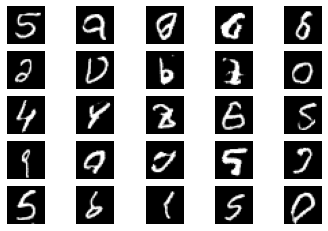

epoch:  87 real samples discriminator accuracy:  10.244536247334755 % real samples discriminator loss:  0.9414955120223926 fake samples discriminator accuracy:  99.77678571428571 % fake samples discriminator loss:  0.38470640619680574
DCGAN accuracy: 0.4006196695095949 % DCGAN loss: 1.120942870881766


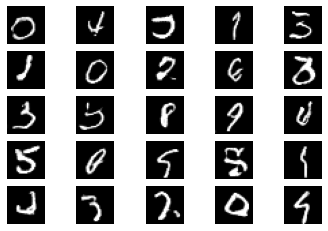

epoch:  88 real samples discriminator accuracy:  9.343350213219615 % real samples discriminator loss:  0.9579907398361133 fake samples discriminator accuracy:  99.90005330490405 % fake samples discriminator loss:  0.37489768043001576
DCGAN accuracy: 0.19906050106609807 % DCGAN loss: 1.1431320284221218


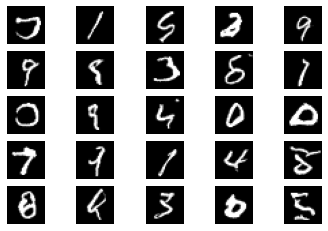

epoch:  89 real samples discriminator accuracy:  9.776452558635395 % real samples discriminator loss:  0.956769346873135 fake samples discriminator accuracy:  99.88506130063965 % fake samples discriminator loss:  0.37353220416792926
DCGAN accuracy: 0.27901785714285715 % DCGAN loss: 1.1455078087508805


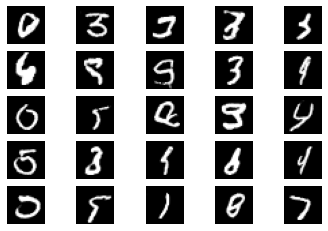

epoch:  90 real samples discriminator accuracy:  9.926372601279319 % real samples discriminator loss:  0.9591904724838891 fake samples discriminator accuracy:  99.90838219616205 % fake samples discriminator loss:  0.37084250145756614
DCGAN accuracy: 0.24986673773987209 % DCGAN loss: 1.1524986679365894


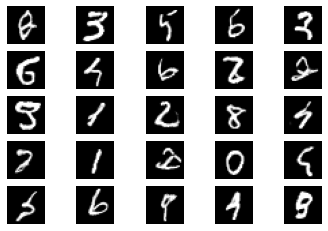

epoch:  91 real samples discriminator accuracy:  10.557702558635395 % real samples discriminator loss:  0.9517399863139399 fake samples discriminator accuracy:  99.83508795309169 % fake samples discriminator loss:  0.3731753950688376
DCGAN accuracy: 0.3464818763326226 % DCGAN loss: 1.1453562012867633


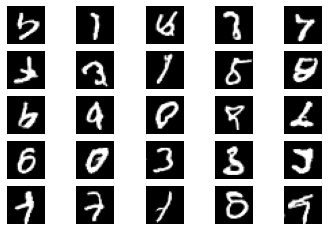

epoch:  92 real samples discriminator accuracy:  11.247334754797441 % real samples discriminator loss:  0.9467210006485107 fake samples discriminator accuracy:  99.87006929637526 % fake samples discriminator loss:  0.37514469332532335
DCGAN accuracy: 0.35980810234541577 % DCGAN loss: 1.142445247119932


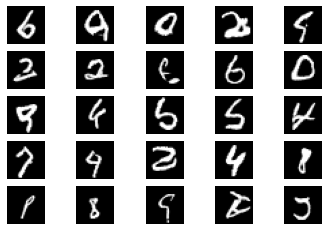

epoch:  93 real samples discriminator accuracy:  10.91751066098081 % real samples discriminator loss:  0.9521266382132003 fake samples discriminator accuracy:  99.82842484008529 % fake samples discriminator loss:  0.37053825628401627
DCGAN accuracy: 0.34148454157782515 % DCGAN loss: 1.1503829481378038


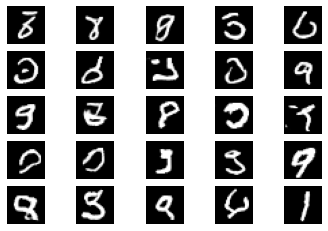

epoch:  94 real samples discriminator accuracy:  11.085754264392325 % real samples discriminator loss:  0.9558741492884499 fake samples discriminator accuracy:  99.83841950959487 % fake samples discriminator loss:  0.36756944011396436
DCGAN accuracy: 0.3381529850746268 % DCGAN loss: 1.1595644537828116


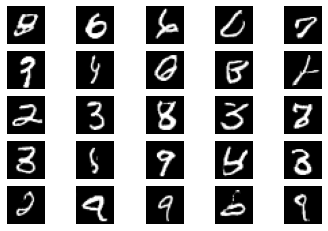

epoch:  95 real samples discriminator accuracy:  11.537180170575693 % real samples discriminator loss:  0.951151750870605 fake samples discriminator accuracy:  99.83841950959487 % fake samples discriminator loss:  0.36817099128577757
DCGAN accuracy: 0.37729877398720685 % DCGAN loss: 1.157579169789357


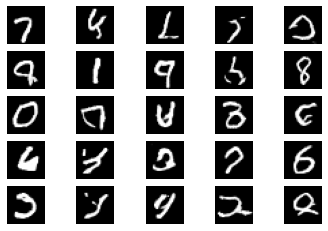

epoch:  96 real samples discriminator accuracy:  11.382262793176972 % real samples discriminator loss:  0.9513047391544781 fake samples discriminator accuracy:  99.88506130063965 % fake samples discriminator loss:  0.3669873160530509
DCGAN accuracy: 0.34231743070362475 % DCGAN loss: 1.1580385741140289


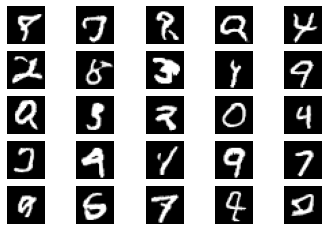

epoch:  97 real samples discriminator accuracy:  11.708755330490405 % real samples discriminator loss:  0.9530839866666652 fake samples discriminator accuracy:  99.88506130063965 % fake samples discriminator loss:  0.3634146806527811
DCGAN accuracy: 0.29484275053304904 % DCGAN loss: 1.167404333983403


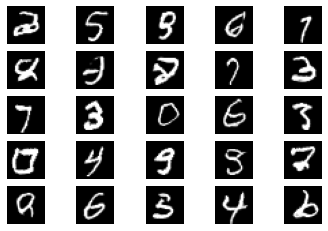

epoch:  98 real samples discriminator accuracy:  11.393923240938166 % real samples discriminator loss:  0.9593348741404283 fake samples discriminator accuracy:  99.89672174840085 % fake samples discriminator loss:  0.35942735667548964
DCGAN accuracy: 0.2756863006396589 % DCGAN loss: 1.1768154370378074


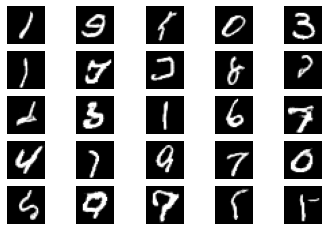

epoch:  99 real samples discriminator accuracy:  12.195162579957355 % real samples discriminator loss:  0.9510304599301393 fake samples discriminator accuracy:  99.84841417910447 % fake samples discriminator loss:  0.3626532973384044
DCGAN accuracy: 0.265691631130064 % DCGAN loss: 1.1701757526601047


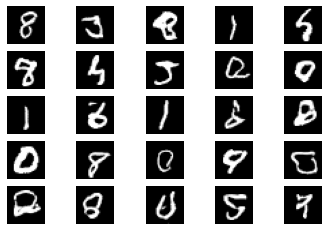

epoch:  100 real samples discriminator accuracy:  11.865338486140725 % real samples discriminator loss:  0.9585244153608391 fake samples discriminator accuracy:  99.84841417910447 % fake samples discriminator loss:  0.3569291780180514
DCGAN accuracy: 0.3106676439232409 % DCGAN loss: 1.1819959160869817


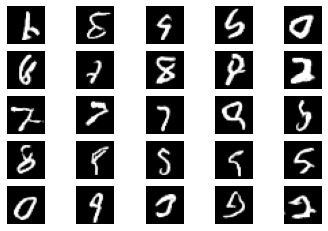

epoch:  101 real samples discriminator accuracy:  12.821495202558635 % real samples discriminator loss:  0.9540059895657781 fake samples discriminator accuracy:  99.86007462686567 % fake samples discriminator loss:  0.3571880837874626
DCGAN accuracy: 0.3614738805970149 % DCGAN loss: 1.180217286607604


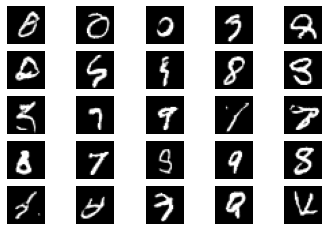

epoch:  102 real samples discriminator accuracy:  12.446695095948828 % real samples discriminator loss:  0.9605017374319308 fake samples discriminator accuracy:  99.86840351812367 % fake samples discriminator loss:  0.3533398428800772
DCGAN accuracy: 0.33565431769722814 % DCGAN loss: 1.1899250237418135


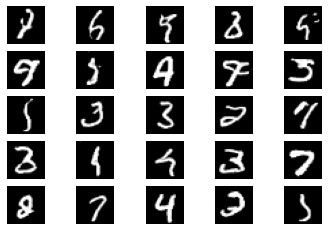

epoch:  103 real samples discriminator accuracy:  12.425039978678038 % real samples discriminator loss:  0.9622383507838381 fake samples discriminator accuracy:  99.88839285714286 % fake samples discriminator loss:  0.3516316808648963
DCGAN accuracy: 0.29817430703624737 % DCGAN loss: 1.194890729336342


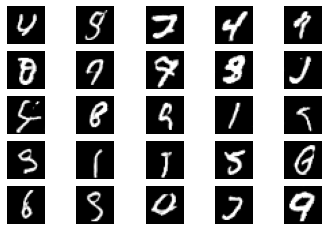

epoch:  104 real samples discriminator accuracy:  12.698227611940299 % real samples discriminator loss:  0.9619808490596601 fake samples discriminator accuracy:  99.87340085287848 % fake samples discriminator loss:  0.3510365936357075
DCGAN accuracy: 0.3264925373134328 % DCGAN loss: 1.1964810328570001


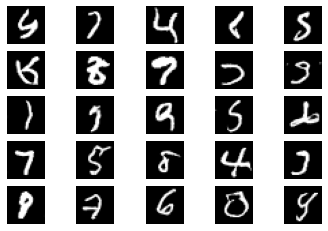

epoch:  105 real samples discriminator accuracy:  12.365071961620469 % real samples discriminator loss:  0.9633381193888976 fake samples discriminator accuracy:  99.86507196162047 % fake samples discriminator loss:  0.3494983046039589
DCGAN accuracy: 0.28318230277185497 % DCGAN loss: 1.1996930723251311


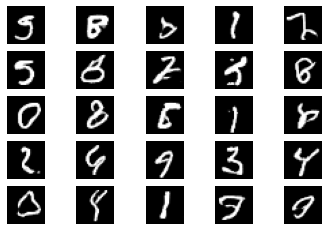

epoch:  106 real samples discriminator accuracy:  13.229610874200425 % real samples discriminator loss:  0.9621349128960038 fake samples discriminator accuracy:  99.83342217484008 % fake samples discriminator loss:  0.3481666207440626
DCGAN accuracy: 0.37646588486140725 % DCGAN loss: 1.201281051137554


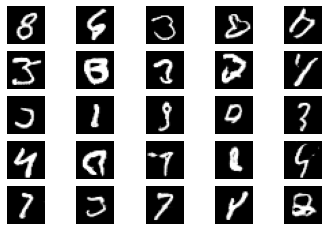

epoch:  107 real samples discriminator accuracy:  12.771521855010661 % real samples discriminator loss:  0.9744592978756057 fake samples discriminator accuracy:  99.8267590618337 % fake samples discriminator loss:  0.3419651400877723
DCGAN accuracy: 0.34231743070362475 % DCGAN loss: 1.2200317306559223


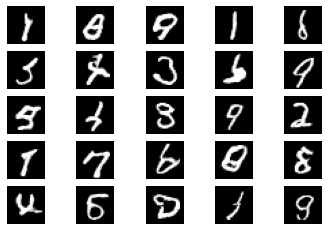

epoch:  108 real samples discriminator accuracy:  13.196295309168443 % real samples discriminator loss:  0.9729312060992601 fake samples discriminator accuracy:  99.87340085287848 % fake samples discriminator loss:  0.3405970407606188
DCGAN accuracy: 0.3689698827292111 % DCGAN loss: 1.2224800711247459


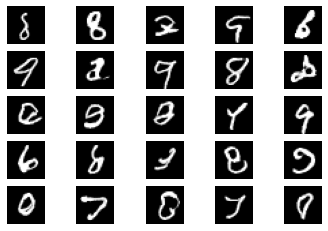

epoch:  109 real samples discriminator accuracy:  13.051372601279319 % real samples discriminator loss:  0.9734796219543099 fake samples discriminator accuracy:  99.83508795309169 % fake samples discriminator loss:  0.3394692441198363
DCGAN accuracy: 0.30150586353944564 % DCGAN loss: 1.224867318802551


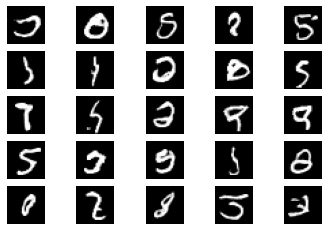

epoch:  110 real samples discriminator accuracy:  13.760994136460555 % real samples discriminator loss:  0.9646303373486248 fake samples discriminator accuracy:  99.8367537313433 % fake samples discriminator loss:  0.3425998309496115
DCGAN accuracy: 0.3364872068230277 % DCGAN loss: 1.2173371149151564


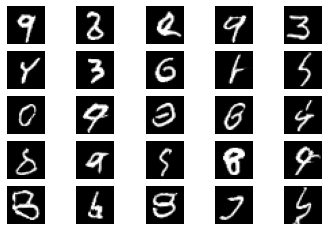

epoch:  111 real samples discriminator accuracy:  13.802638592750533 % real samples discriminator loss:  0.9634264222721556 fake samples discriminator accuracy:  99.83508795309169 % fake samples discriminator loss:  0.3414369645689342
DCGAN accuracy: 0.3606409914712153 % DCGAN loss: 1.219861282214427


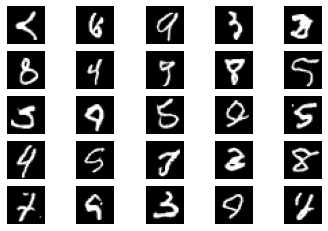

epoch:  112 real samples discriminator accuracy:  13.717683901918976 % real samples discriminator loss:  0.968291155755647 fake samples discriminator accuracy:  99.84508262260128 % fake samples discriminator loss:  0.33828493326838843
DCGAN accuracy: 0.378964552238806 % DCGAN loss: 1.2267822619440205


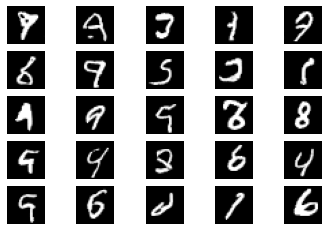

epoch:  113 real samples discriminator accuracy:  14.162446695095948 % real samples discriminator loss:  0.9709382692633916 fake samples discriminator accuracy:  99.82842484008529 % fake samples discriminator loss:  0.3347518298068026
DCGAN accuracy: 0.40395122601279315 % DCGAN loss: 1.234244331367997


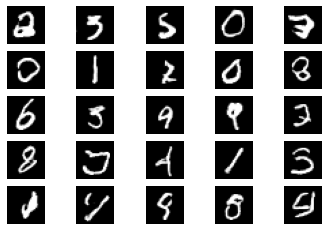

epoch:  114 real samples discriminator accuracy:  14.525586353944565 % real samples discriminator loss:  0.9635410381278504 fake samples discriminator accuracy:  99.82009594882729 % fake samples discriminator loss:  0.33793156017372605
DCGAN accuracy: 0.40561700426439234 % DCGAN loss: 1.2276485916902262


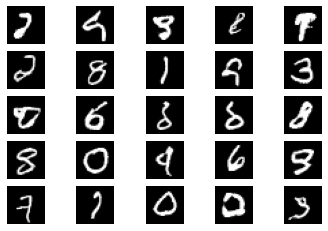

epoch:  115 real samples discriminator accuracy:  15.423440831556503 % real samples discriminator loss:  0.9582697326567635 fake samples discriminator accuracy:  99.8051039445629 % fake samples discriminator loss:  0.3380520667698083
DCGAN accuracy: 0.4422641257995736 % DCGAN loss: 1.2272610291997508


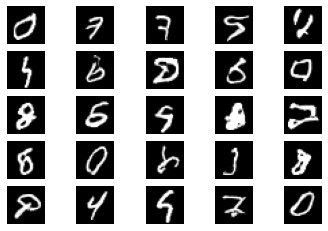

epoch:  116 real samples discriminator accuracy:  16.391257995735607 % real samples discriminator loss:  0.940993954504985 fake samples discriminator accuracy:  99.78844616204691 % fake samples discriminator loss:  0.3460478724034102
DCGAN accuracy: 0.5522054904051172 % DCGAN loss: 1.2101181762686162


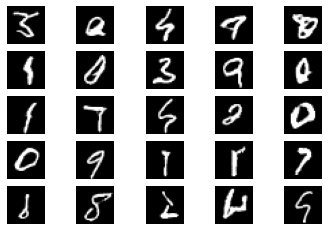

epoch:  117 real samples discriminator accuracy:  15.698294243070363 % real samples discriminator loss:  0.9545987261129595 fake samples discriminator accuracy:  99.73014392324095 % fake samples discriminator loss:  0.338374541464772
DCGAN accuracy: 0.5338819296375266 % DCGAN loss: 1.2273963021317016


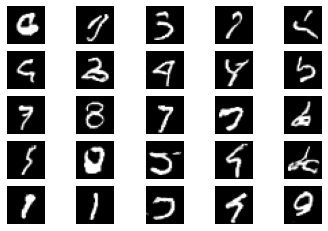

epoch:  118 real samples discriminator accuracy:  15.934834754797441 % real samples discriminator loss:  0.9571854743494916 fake samples discriminator accuracy:  99.79011194029852 % fake samples discriminator loss:  0.3364204007711238
DCGAN accuracy: 0.5072294776119403 % DCGAN loss: 1.2326814743247367


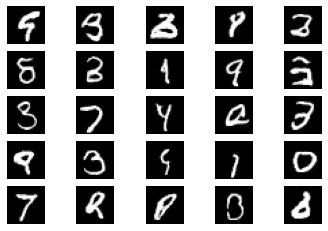

epoch:  119 real samples discriminator accuracy:  16.787713219616204 % real samples discriminator loss:  0.9527563992212577 fake samples discriminator accuracy:  99.72181503198294 % fake samples discriminator loss:  0.3368359443856709
DCGAN accuracy: 0.5755263859275053 % DCGAN loss: 1.229785261822662


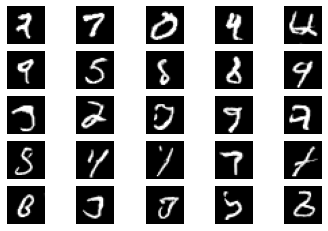

epoch:  120 real samples discriminator accuracy:  16.146388592750533 % real samples discriminator loss:  0.9590276414905784 fake samples discriminator accuracy:  99.79677505330491 % fake samples discriminator loss:  0.33037400452185794
DCGAN accuracy: 0.45975479744136455 % DCGAN loss: 1.2452618568055411


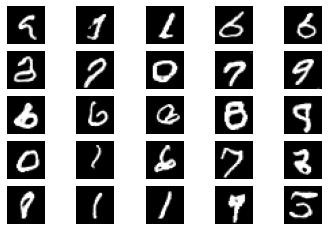

epoch:  121 real samples discriminator accuracy:  16.123067697228144 % real samples discriminator loss:  0.9598916625417372 fake samples discriminator accuracy:  99.77511993603412 % fake samples discriminator loss:  0.3288642409990337
DCGAN accuracy: 0.45559035181236673 % DCGAN loss: 1.250197936604018


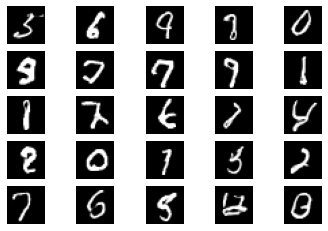

epoch:  122 real samples discriminator accuracy:  17.94709488272921 % real samples discriminator loss:  0.9456680601975048 fake samples discriminator accuracy:  99.73180970149254 % fake samples discriminator loss:  0.3334705882679933
DCGAN accuracy: 0.6205023987206822 % DCGAN loss: 1.2374808584322046


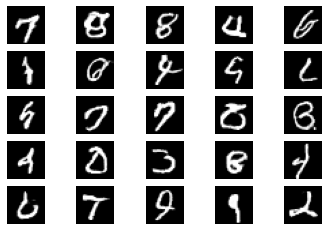

epoch:  123 real samples discriminator accuracy:  17.655583688699362 % real samples discriminator loss:  0.951194339024741 fake samples discriminator accuracy:  99.75013326226014 % fake samples discriminator loss:  0.32946244536686553
DCGAN accuracy: 0.49723480810234544 % DCGAN loss: 1.2485304437974878


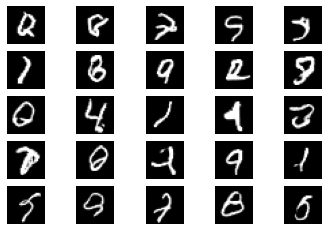

In [ ]:
train(latent_dim, dis, gen, gan, ds_train, batch_size)